In [1]:
import calour as ca
import calour_utils as cu

failed to load logging config file


In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import shutil
import seaborn
import scipy as sp

In [3]:
ca.set_log_level('INFO')

In [4]:
%matplotlib inline

In [5]:
pwd

'/Users/amnon/Projects/sheba/metaanalysis/scripts'

# Load the ratios data

In [6]:
dat=ca.read_amplicon('../ratios/ratios_no_bloom.biom','../studies/index.csv',normalize=None, min_reads=None)

2021-04-05 17:34:25 INFO loaded 59 samples, 731 features


In [7]:
dat.sample_metadata

,disease,authors,dys_number,merged,study,Country,sample_source,updated,notes,2,3,4,5,_sample_id,_calour_original_abundance
sampleid,,,,,,,,,,,,,,,
12,Gastroenteritis,Braun,19,Gastroenteritis (Braun),Braun,Israel,stool,V,NaN,NaN,NaN,NaN,NaN,12,-93.290991
62,Hypertension,UKtwins,29,Hypertension (Uktwins),uktwins,UK,stool,V,females,adults,NaN,NaN,NaN,62,7.427559
50,Autism,Zurita,4,Autism (Zurita),zurita,Ecuador,stool,V,NaN,children,NaN,NaN,NaN,50,10.461171
20,Obesity,Vangay,51,Obesity (Vangay),vangay,Multi,stool,V,NaN,adults,NaN,NaN,NaN,20,-7.058779
45,Irritable bowel syndrom,AGP,44,Irritable bowel syndrom (AGP),AGP,USA,stool,V,NaN,NaN,NaN,NaN,NaN,45,-5.485929
4,Parkinson,Heintz_Buschart,53,Parkinson (Heintz-Buschart),Heintz_Buschart,Germany,stool,V,No gender metadata,adults,NaN,NaN,NaN,4,8.263063
29,IBD_Crohn disease,Gevers,33,IBD_Crohn disease (Gevers),gevers,USA,biposy,V,NaN,children,NaN,NaN,NaN,29,-21.385767
59,Gout,UKtwins,21,Gout (Uktwins),uktwins,UK,stool,V,females,adults,NaN,NaN,NaN,59,-7.433824
40,C.difficile infection,AGP,8,C.difficile infection (AGP),AGP,USA,stool,V,NaN,NaN,NaN,NaN,NaN,40,-13.482759


In [8]:
dat.sparse=False

In [9]:
dat=dat.sort_abundance(key=np.mean)
dat=dat.sort_samples('merged')

In [10]:
# prepare the colormap. white is effect_size 0)
current_cmap = mpl.cm.get_cmap('coolwarm')
current_cmap.set_bad(color='red')

ncm = current_cmap(np.linspace(0,1,1000000))
ncm[500000]=(1,1,1,1)
ncm=mpl.colors.ListedColormap(ncm)

In [12]:
f=dat.plot(sample_field='disease',norm=None,cmap=ncm,clim=[-0.25,0.25],xticks_max=None,xticklabel_len=None,
                   xticklabel_kwargs={'size':8, 'rotation':90}, gui='qt5')

# Calculate the bray-curtis distance on the NRMDs
## Using all features

In [13]:
def bray_curtis_zero(dat1, dat2, skip_zeros=False):
    if skip_zeros:
        okpos = (dat1!=0) & (dat2!=0)
        dat1=dat1[okpos]
        dat2=dat2[okpos]
    dist = np.sum(np.abs(dat1-dat2)) / np.sum(np.abs(dat1) + np.abs(dat2))
    return dist

In [14]:
def get_bc_ratios(exp, skip_zeros=False):
    data = exp.data
    dm = np.zeros([data.shape[0], data.shape[0]])
    for i in range(data.shape[0]):
        for j in range(data.shape[0]):
            dm[i,j] = bray_curtis_zero(data[i,:], data[j,:], skip_zeros)
    return dm

In [23]:
dm=get_bc_ratios(dat, skip_zeros=False)

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


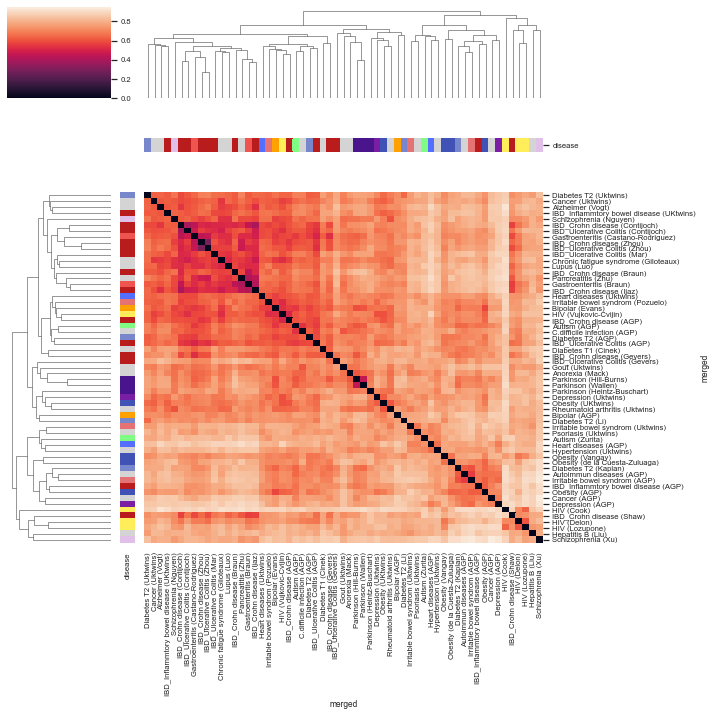

In [24]:
ff=pd.DataFrame(dm,columns=dat.sample_metadata.merged,index=dat.sample_metadata.merged)
seaborn.set(font_scale=0.7)
# set the colors for the labels in the clustermap
labels1 = {xx:(0,0,0) for xx in ff.index.unique()}
labels1.update({'HIV': (1.00,0.93,0.35),'Autism': (0.50,0.99,0.52),'Bipolar': (1.00, 0.63, 0.00),
         'IBD_Crohn disease': (0.72,0.11,0.11),'IBD_Ulcerative Colitis': (0.72,0.11,0.11),
         'IBD_Inflammtory bowel disease': (0.72,0.11,0.11),
         'Diabetes T2': (0.47,0.53,0.80),
         'Depression': (0.48,0.12,0.64),
         'Obesity': (0.25,0.32,0.71),
         'Parkinson': (0.29,0.08,0.55),
         'Schizophrenia': (0.88,0.75,0.91),     
         'Gastroenteritis': (0.94,0.33,0.31),
         'Heart diseases': (0.33,0.43,1.00),
         'Irritable bowel syndrom': (0.90,0.45,0.45),
         'Alzheimer': (0.83, 0.83, 0.83), 'Anorexia': (0.83, 0.83, 0.83), 'Cancer': (0.83, 0.83, 0.83), 'Autoimmun diseases': (0.83, 0.83, 0.83), 'C.difficile infection': (0.83, 0.83, 0.83), 
         'Cancer': (0.83, 0.83, 0.83), 'Chronic fatigue syndrome': (0.83, 0.83, 0.83), 'Diabetes T1': (0.83, 0.83, 0.83),  'Gout': (0.83, 0.83, 0.83),
         'Hepatitis B': (0.83, 0.83, 0.83), 'Hepatitis C': (0.83, 0.83, 0.83), 'Hypertension': (0.83, 0.83, 0.83), 
         'Lupus': (0.83, 0.83, 0.83), 'Pancreatitis': (0.83, 0.83, 0.83), 'Psoriasis': (0.83, 0.83, 0.83), 'Rheumatoid arthritis': (0.83, 0.83, 0.83), 
                
         })
a=dat.sample_metadata.copy()
a=a.set_index('merged')
res=seaborn.clustermap(ff,yticklabels=1,xticklabels=1,
                       row_colors=a.disease.map(labels1),col_colors=a.disease.map(labels1))
plt.tight_layout()
plt.savefig('../figures/fig2/distances-heatmap-ratios-all.pdf')

# Export to qiime2 for PCoA

In [17]:
import skbio
qdm=skbio.DistanceMatrix(dm,dat.sample_metadata._sample_id)

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


In [18]:
pcoa=skbio.stats.ordination.pcoa(qdm)

In [19]:
pcoa.write('../ratios/pcoa-ratios-all.txt')

'../ratios/pcoa-ratios-all.txt'

# to view with qiime2:
## import the pcoa:
qiime tools import --input-path pcoa-ratios-all.txt --output-path pcoa.qza --type PCoAResults
## run emperor to create the qzv visualization
qiime emperor plot --i-pcoa pcoa.qza --m-metadata-file index.csv --o-visualization pita.qzv


# THIS SHOULD GO TO ALL_SAMPLES OR NEW NOTEBOOK - allsamples_distances.ipynb

# Look at sample-wise (not ratio - but mean over all individuals)

In [6]:
sd=ca.read_amplicon('../allsamples/cohort-disease-mean.biom','../allsamples/cohort-disease-mean_sample.txt',normalize=10000,min_reads=0, sparse=False)
sd

2021-05-10 19:47:40 INFO loaded 118 samples, 44526 features
2021-05-10 19:47:40 WARNING Do you forget to normalize your data? It is required before running this function
2021-05-10 19:47:40 INFO After filtering, 118 remain.


AmpliconExperiment with 118 samples, 44526 features

## Get the bray-curtis distance matrix
Without ignoring ASVs that are 0 (not present) in one of the studies

In [26]:
dm_samp=get_bc_ratios(sd)

### Just look how the all_samples mean distance matrix looks

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


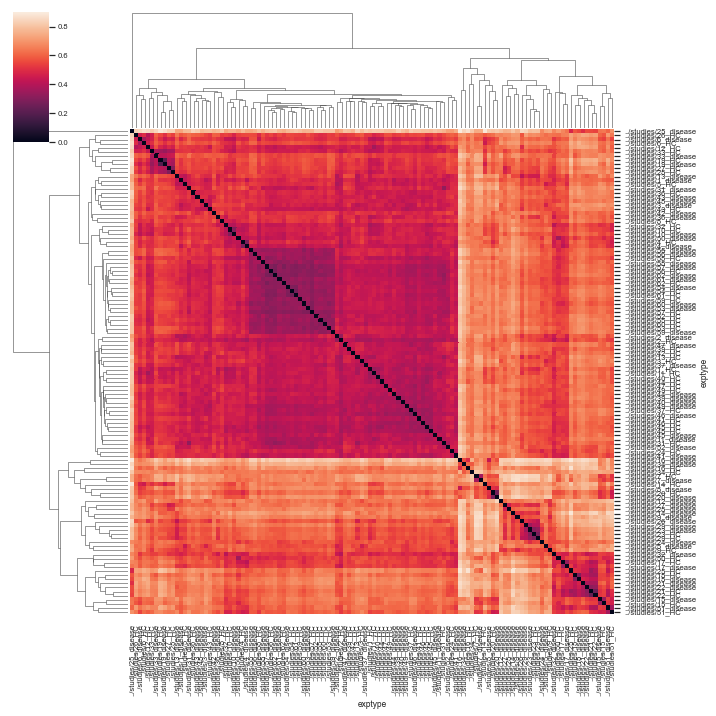

In [27]:
ff=pd.DataFrame(dm_samp,columns=sd.sample_metadata.exptype,index=sd.sample_metadata.exptype)

seaborn.clustermap(ff,yticklabels=1,xticklabels=1)

## Get the bray-curtis distance matrix
Ignoring ASVs that are 0 (not present) in one of the studies

In [28]:
dm_samp_nozeros=get_bc_ratios(sd, skip_zeros=True)

### And look at the distance matrix using the bray-curtis no zeros metric

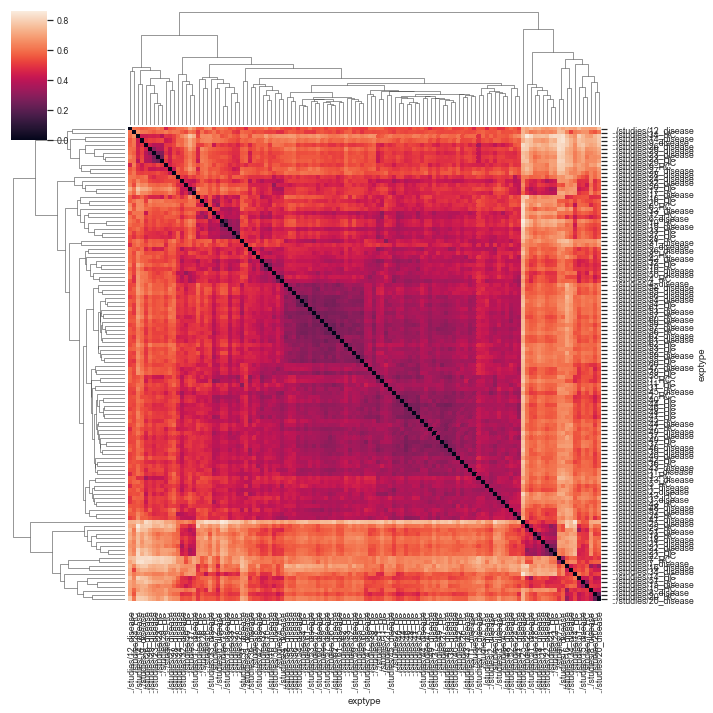

In [29]:
ff=pd.DataFrame(dm_samp_nozeros,columns=sd.sample_metadata.exptype,index=sd.sample_metadata.exptype)

seaborn.set(font_scale=0.8)

seaborn.clustermap(ff,yticklabels=1,xticklabels=1)


### Now convert to qiime2 format

### With zeros

In [30]:
qdm_samp=skbio.DistanceMatrix(dm_samp,sd.sample_metadata._sample_id)
pcoa_samp=skbio.stats.ordination.pcoa(qdm_samp)
pcoa_samp.write('../ratios/pcoa-samples-zero.txt')

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.024273321002794886 and the largest is 2.9934897535322436.
  RuntimeWarning


'../ratios/pcoa-samples-zero.txt'

### Without zeros (ignoring ASVs not found in one of the experiments)

In [31]:
qdm_samp_no_zeros=skbio.DistanceMatrix(dm_samp_nozeros,sd.sample_metadata._sample_id)
pcoa_samp_no_zeros=skbio.stats.ordination.pcoa(qdm_samp_no_zeros)
pcoa_samp_no_zeros.write('../ratios/pcoa-samples-nozero.txt')

/Users/amnon/miniconda3/envs/calour/lib/python3.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.09458106559659973 and the largest is 2.912769102909251.
  RuntimeWarning


'../ratios/pcoa-samples-nozero.txt'

# Look at within/ between cohort/disease distance distribution

In [32]:
def draw_cohort_type_histograms(distmat, sample_metadata):
    same_exp=[]
    diff_exp_hc=[]
    diff_exp_disease=[]
    for i, csamp in enumerate(sample_metadata.iterrows()):
        exp1 = csamp[1]['exp']
        type1 = csamp[1]['type']
        for j, csamp2 in enumerate(sample_metadata.iterrows()):
            exp2 = csamp2[1]['exp']
            type2 = csamp2[1]['type']
            if (exp2==exp1) and (type2==type1):
                continue
            if exp1==exp2:
                same_exp.append(distmat[i,j])
            elif type1==type2:
                if type1=='HC':
                    diff_exp_hc.append(distmat[i,j])
                else:
                    diff_exp_disease.append(distmat[i,j])
    f1=plt.figure()
    plt.hist(same_exp)
    plt.xlim([0,1])
    plt.title('same experiment HC-disease distance')
    f2=plt.figure()
    plt.hist(diff_exp_hc)
    plt.xlim([0,1])
    plt.title('different experiment HC-HC distance')
    f3=plt.figure()
    plt.hist(diff_exp_disease)
    plt.xlim([0,1])
    plt.title('different experiment disease-disease distance')
    res = sp.stats.mannwhitneyu(same_exp,diff_exp_hc)
    print('SAME_EXP (%f) vs. DIFF_EXP_HC (%f): %s' % (np.mean(same_exp),np.mean(diff_exp_hc),res[1]))
    res = sp.stats.mannwhitneyu(same_exp,diff_exp_disease)
    print('SAME_EXP (%f) vs. DIFF_EXP_DISEASE (%f): %s' % (np.mean(same_exp), np.mean(diff_exp_disease), res[1]))
    res = sp.stats.mannwhitneyu(diff_exp_hc, diff_exp_disease)
    print('DIFF_EXP_HC (%f) vs DIFF_EXP_DISEASE (%f): %s' % (np.mean(diff_exp_hc), np.mean(diff_exp_disease), res[1]))
    return f1,f2,f3

## With zeros (all ASVs)

SAME_EXP (0.402289) vs. DIFF_EXP_HC (0.530641): 1.1912153542705381e-33
SAME_EXP (0.402289) vs. DIFF_EXP_DISEASE (0.583806): 1.6904519823127673e-45
DIFF_EXP_HC (0.530641) vs DIFF_EXP_DISEASE (0.583806): 3.462513463278998e-69


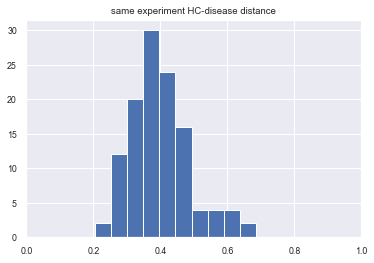

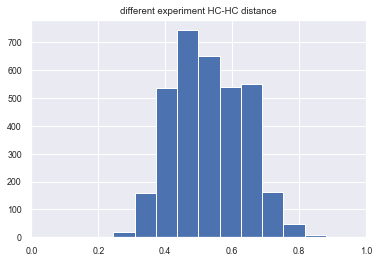

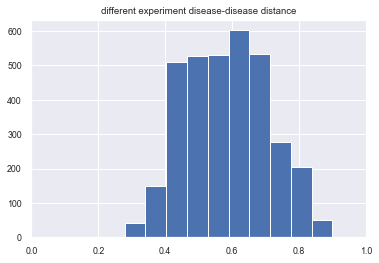

In [33]:
f1,f2,f3=draw_cohort_type_histograms(dm_samp, sd.sample_metadata)

In [34]:
f1.savefig('../figures/distances-allsamples-same-cohort-hc-disease.pdf')
f2.savefig('../figures/distances-allsamples-diff-cohort-hc-hc.pdf')
f3.savefig('../figures/distances-allsamples-diff-cohort-disease-disease.pdf')

## Without zeros (ignoring ASVs not present in one experiment)

SAME_EXP (0.350432) vs. DIFF_EXP_HC (0.463249): 1.1781050938569234e-29
SAME_EXP (0.350432) vs. DIFF_EXP_DISEASE (0.513795): 2.605059665150467e-43
DIFF_EXP_HC (0.463249) vs DIFF_EXP_DISEASE (0.513795): 3.3822040606587235e-65


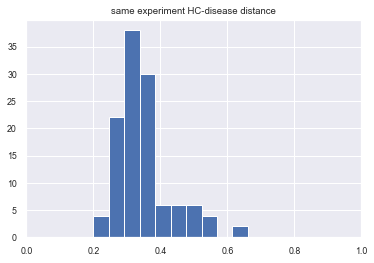

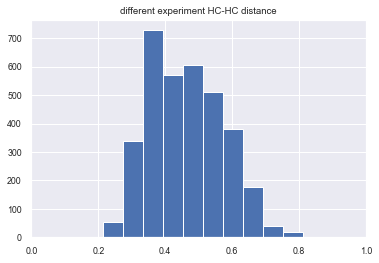

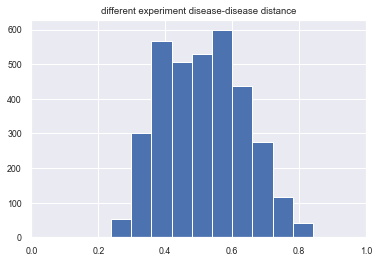

In [35]:
f1,f3,f3=draw_cohort_type_histograms(dm_samp_nozeros, sd.sample_metadata)